# Can We Predict Churn Rate?: The Lifeline of Startups and Their Customers: Data Cleaning and Prep

In this section, we prepare the data for analysis by addressing outliers, handling null values, and performing feature engineering.

In [2]:
# Import packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
# Loading and initial exploration of datasets
train_dataset = pd.read_csv('data/train_dataset.csv')

In [4]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 970960 entries, 0 to 970959
Data columns (total 23 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   msno                    970960 non-null  object 
 1   is_churn                970960 non-null  int64  
 2   city                    860967 non-null  float64
 3   bd                      860967 non-null  float64
 4   gender                  388905 non-null  object 
 5   registered_via          860967 non-null  float64
 6   registration_init_time  860967 non-null  float64
 7   payment_method_id       933578 non-null  float64
 8   payment_plan_days       933578 non-null  float64
 9   plan_list_price         933578 non-null  float64
 10  actual_amount_paid      933578 non-null  float64
 11  is_auto_renew           933578 non-null  float64
 12  transaction_date        933578 non-null  float64
 13  membership_expire_date  933578 non-null  object 
 14  is_cancel           

## Data Cleaning

In [5]:
train_cleaned = train_dataset.copy()

### Addressing Outliers

#### Age

Let's take a look at the impact of outliers again with the post-merged data.

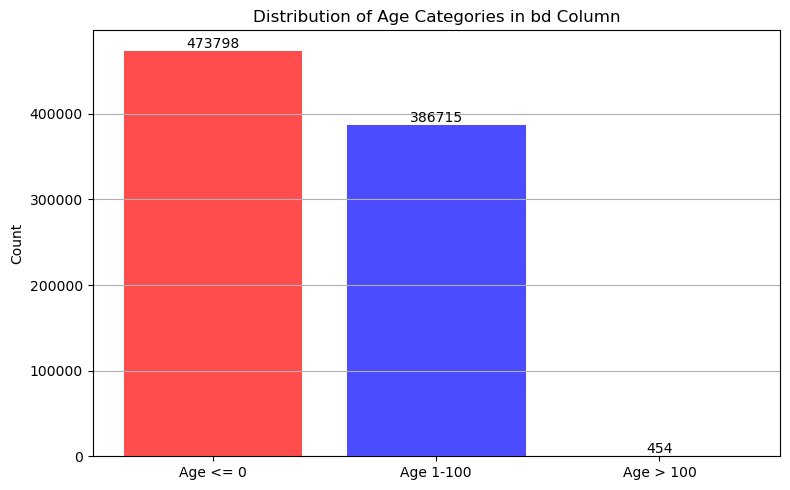

In [6]:
# Categorize the data based on the age
age_under0 = train_dataset[train_dataset['bd'] <= 0]['bd'].count()
age_1_to_100 = train_dataset[(train_dataset['bd'] > 0) & (train_dataset['bd'] <= 100)]['bd'].count()
age_greater_than_100 = train_dataset[train_dataset['bd'] > 100]['bd'].count()

# Data for plotting
categories = ['Age <= 0', 'Age 1-100', 'Age > 100']
values = [age_under0, age_1_to_100, age_greater_than_100]

# Plotting the histogram with the counts above each bar
plt.figure(figsize=(8, 5))
colors = ['red', 'blue', 'red']
bars = plt.bar(categories, values, color=colors, alpha=0.7)

# Adding the count above each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 50, round(yval, 2), ha='center', va='bottom', fontsize=10)

plt.title('Distribution of Age Categories in bd Column')
plt.ylabel('Count')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

While there are several outliers below the age of 0 and above 100, a significant amount of data is also missing. If we simply set these missing values as null during the final null-value deletion, it could lead to substantial data loss. Therefore, we will adopt the following approach:

1. Outliers will be treated as null values.
2. Subsequently, null values will be imputed using the median of the entire dataset.

In [7]:
# Count the number of outliers in the 'bd' column
invalid_age_count_train = train_dataset[(train_dataset.bd <= 0) | (train_dataset.bd > 100)].shape[0]

print('outliers bd train:', invalid_age_count_train)

outliers bd train: 474252


In [8]:
# Calculate the median of the 'bd' column
train_median_age = train_dataset['bd'].median()

# Replace the outliers in the 'bd' column with the median
train_cleaned['bd'].mask(((train_cleaned.bd <= 0) | (train_cleaned.bd > 100)), other=train_median_age, inplace=True)

### Impute null-values

In [9]:
train_cleaned.isnull().sum()

msno                           0
is_churn                       0
city                      109993
bd                        109993
gender                    582055
registered_via            109993
registration_init_time    109993
payment_method_id          37382
payment_plan_days          37382
plan_list_price            37382
actual_amount_paid         37382
is_auto_renew              37382
transaction_date           37382
membership_expire_date     37382
is_cancel                  37382
num_25_sum                216409
num_50_sum                216409
num_75_sum                216409
num_985_sum               216409
num_100_sum               216409
num_unq_sum               216409
total_secs_sum            216409
msno_count                216409
dtype: int64

#### Gender

More than half of the data in the 'gender' column is missing. Instead of dropping all of them, which would lead to significant data loss, the missing values will be replaced with '0'.

In [10]:
train_cleaned['gender'] = train_cleaned['gender'].replace(to_replace='male', value=1)
train_cleaned['gender'] = train_cleaned['gender'].replace(to_replace='female', value=2)
train_cleaned['gender'] = train_cleaned['gender'].fillna(0)
train_cleaned['gender'] = train_cleaned['gender'].astype(int)

### Drop other null-values

We've organized the 'Gender' column. For other columns where imputation is challenging and data loss is acceptable, we plan to drop the remaining null values.

In [11]:
# Remove rows containing null values
train_cleaned = train_cleaned.dropna()

# Check there is no null values in the dataset
train_cleaned.isnull().sum()

msno                      0
is_churn                  0
city                      0
bd                        0
gender                    0
registered_via            0
registration_init_time    0
payment_method_id         0
payment_plan_days         0
plan_list_price           0
actual_amount_paid        0
is_auto_renew             0
transaction_date          0
membership_expire_date    0
is_cancel                 0
num_25_sum                0
num_50_sum                0
num_75_sum                0
num_985_sum               0
num_100_sum               0
num_unq_sum               0
total_secs_sum            0
msno_count                0
dtype: int64

In [12]:
rows_before = train_dataset.shape[0]
rows_after = train_cleaned.shape[0]
removed_rows = rows_before - rows_after

rows_before, print(removed_rows)

245238


(970960, None)

We removed 245,238 rows, leaving 970,960 data points remaining. With this number of data points, we can consider the dataset to be reasonably ample for analysis.

### Convert Categorical Column

From this point, let's consider strategies for handling various categorical columns in the dataset.

#### City

Let's examine the distribution of the data and its relationship with the churn rate.

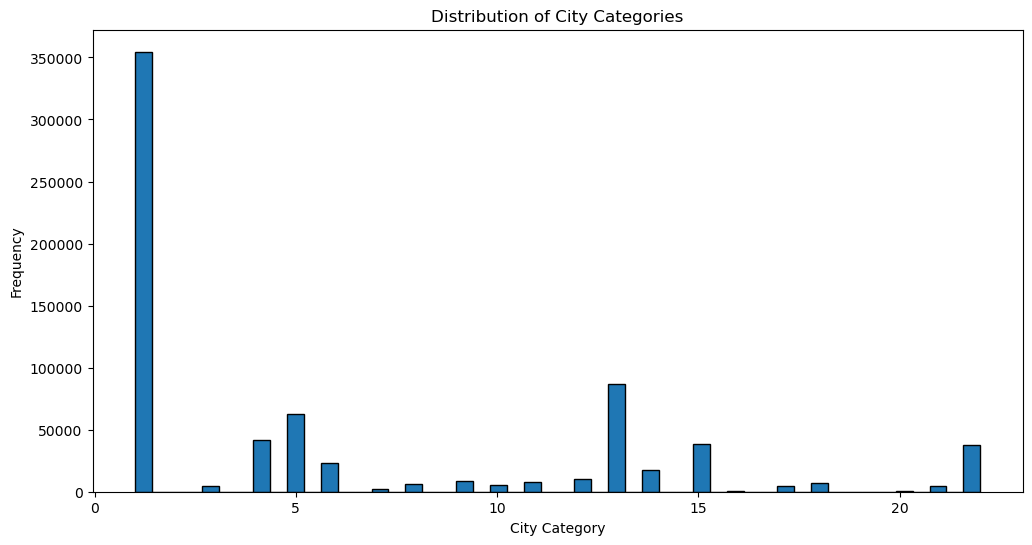

In [13]:
# Plot a histogram for the 'city' column
plt.figure(figsize=(12, 6))
train_cleaned['city'].hist(bins=50, edgecolor='black')
plt.title('Distribution of City Categories')
plt.xlabel('City Category')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()

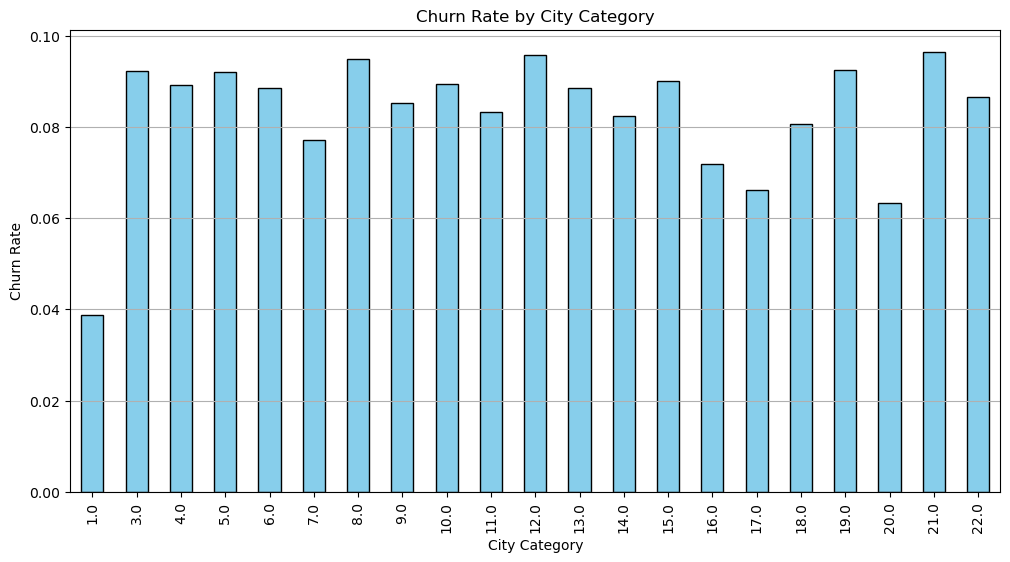

In [14]:
# Calculate the mean churn rate for each city category
city_churn_rate = train_cleaned.groupby('city')['is_churn'].mean()

# Plot the churn rate for each city category
plt.figure(figsize=(12, 6))
city_churn_rate.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Churn Rate by City Category')
plt.xlabel('City Category')
plt.ylabel('Churn Rate')
plt.grid(axis='y')
plt.show()


We calculates the frequency of each category in the 'city' column of the dataset. It then identifies city categories with occurrences below a 5% threshold of the dataset size and replaces those infrequent categories with 'Other' in a new 'city_agg' column. 

In [15]:
# Calculate the frequency of each category in the 'city' column
city_counts = train_cleaned['city'].value_counts()

# Threshold for frequency-based aggregation (5% of the dataset)
threshold = 0.05 * len(train_cleaned)

# Identify city categories that fall below the threshold
infrequent_cities = city_counts[city_counts < threshold].index

# Replace infrequent city categories with 'Other'
train_cleaned['city_agg'] = train_cleaned['city'].replace(infrequent_cities, 'Other')

# Drop the original 'city' column
train_cleaned.drop('city', axis=1, inplace=True)

# Display the value counts for the aggregated city column
train_cleaned['city_agg'].value_counts()


1.0      354610
Other    103913
13.0      87179
5.0       62549
4.0       41968
15.0      38238
22.0      37265
Name: city_agg, dtype: int64

#### payment_method_id

Similarly, we'll examine the distribution of the data and then consider strategies to address the relationship with churn for other categorical columns.

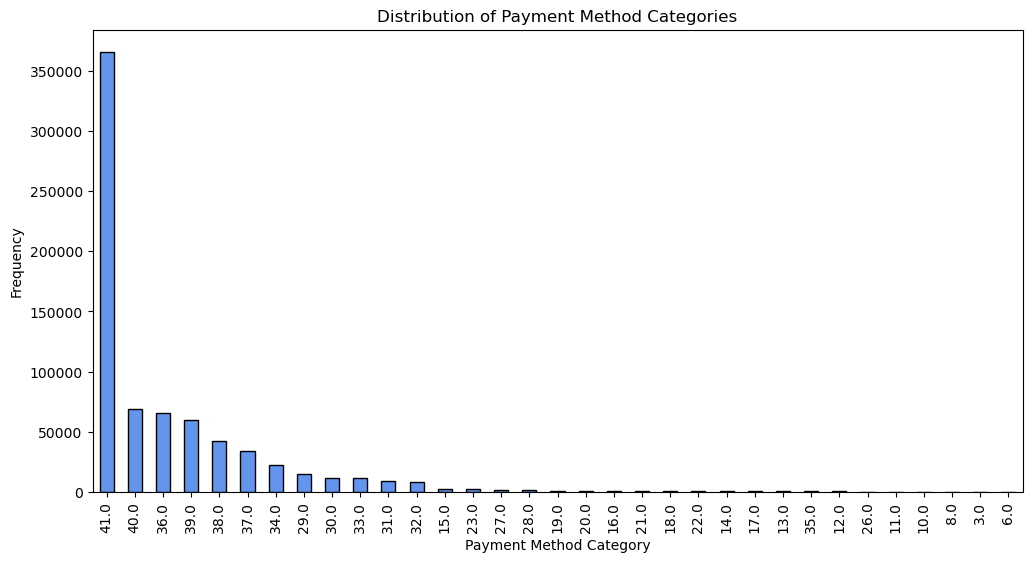

In [16]:
# Plot a histogram for the 'payment_method_id_agg' column
plt.figure(figsize=(12, 6))
train_cleaned['payment_method_id'].value_counts().plot(kind='bar', color='cornflowerblue', edgecolor='black')
plt.title('Distribution of Payment Method Categories')
plt.xlabel('Payment Method Category')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()

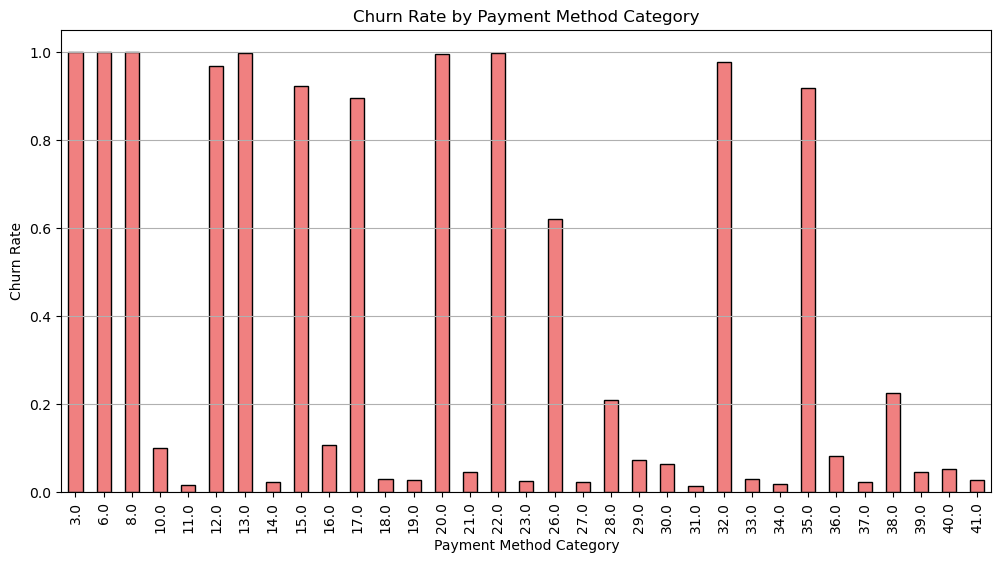

In [17]:
# Calculate the mean churn rate for each city category
churn_rate_per_payment_method = train_cleaned.groupby('payment_method_id')['is_churn'].mean()

# Plot the churn rate for each aggregated payment_method_id category
plt.figure(figsize=(12, 6))
churn_rate_per_payment_method.plot(kind='bar', color='lightcoral', edgecolor='black')
plt.title('Churn Rate by Payment Method Category')
plt.xlabel('Payment Method Category')
plt.ylabel('Churn Rate')
plt.grid(axis='y')
plt.show()

The Churn rate being 1 for many data points is likely due to a limited presence of Payment methods other than 41. This could potentially introduce a skewed distribution, as a small amount of data is causing this imbalance.

Here, we aggregate infrequent payment method categories into an 'Other' category to address potential data skewness in Churn rates.

In [18]:
# Calculate the frequency of each category in the 'payment_method_id' column
payment_method_counts = train_cleaned['payment_method_id'].value_counts()

# Identify payment_method categories that fall below the threshold
infrequent_payment_methods = payment_method_counts[payment_method_counts < threshold].index

# Replace infrequent payment_method categories with 'Other'
train_cleaned['payment_method_id_agg'] = train_cleaned['payment_method_id'].replace(infrequent_payment_methods, 'Other')

# Drop the original 'payment_method_id' column
train_cleaned.drop('payment_method_id', axis=1, inplace=True)

# Display the value counts for the aggregated payment_method_id column
train_cleaned['payment_method_id_agg'].value_counts()

41.0     366009
Other    123704
40.0      68894
36.0      65883
39.0      59301
38.0      41931
Name: payment_method_id_agg, dtype: int64

### One-hot encoding

Converting the categorical columns that we've been addressing into numerical format using one-hot encoding.

In [19]:
# Apply one-hot encoding directly to train_cleaned
train_cleaned = pd.get_dummies(train_cleaned, columns=['city_agg', 'gender', 'registered_via', 'payment_method_id_agg'], drop_first=True)

# Display the first few rows of the updated dataset
train_cleaned.head()

,msno,is_churn,bd,registration_init_time,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,...,gender_2,registered_via_4.0,registered_via_7.0,registered_via_9.0,registered_via_13.0,payment_method_id_agg_38.0,payment_method_id_agg_39.0,payment_method_id_agg_40.0,payment_method_id_agg_41.0,payment_method_id_agg_Other
1,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,1,20.0,20131223.0,30.0,180.0,180.0,0.0,20170311.0,2017-04-11,...,0,0,0,0,0,0,0,0,0,0
2,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,1,18.0,20131227.0,90.0,300.0,300.0,0.0,20170314.0,2017-06-15,...,0,0,0,0,0,0,0,0,0,1
4,K6fja4+jmoZ5xG6BypqX80Uw/XKpMgrEMdG2edFOxnA=,1,35.0,20140125.0,30.0,99.0,99.0,1.0,20170316.0,2017-09-18,...,1,0,1,0,0,0,0,0,1,0
5,ibIHVYBqxGwrSExE63/omeDD99M5vYB3CN2HzkEY+eM=,1,0.0,20140126.0,30.0,149.0,149.0,1.0,20170316.0,2017-03-14,...,0,0,0,0,0,0,0,1,0,0
7,moRTKhKIDvb+C8ZHOgmaF4dXMLk0jOn65d7a8tQ2Eds=,1,28.0,20140202.0,410.0,1788.0,1788.0,0.0,20170324.0,2018-05-13,...,1,0,0,0,0,1,0,0,0,0


### Convert datatypes

Converting the columns that are not in numerical format into numerical columns.

In [20]:
# Convert date columns to datetime format
train_cleaned['transaction_date'] = pd.to_datetime(train_cleaned['transaction_date'])
train_cleaned['membership_expire_date'] = pd.to_datetime(train_cleaned['membership_expire_date'])


In [21]:
# Convert each specified column to integer data type individually
train_cleaned['bd'] = train_cleaned['bd'].astype(int)
train_cleaned['payment_plan_days'] = train_cleaned['payment_plan_days'].astype(int)
train_cleaned['is_auto_renew'] = train_cleaned['is_auto_renew'].astype(int)
train_cleaned['is_cancel'] = train_cleaned['is_cancel'].astype(int)

In [22]:
# Check the data types after conversion
train_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 725722 entries, 1 to 970958
Data columns (total 36 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   msno                         725722 non-null  object        
 1   is_churn                     725722 non-null  int64         
 2   bd                           725722 non-null  int64         
 3   registration_init_time       725722 non-null  float64       
 4   payment_plan_days            725722 non-null  int64         
 5   plan_list_price              725722 non-null  float64       
 6   actual_amount_paid           725722 non-null  float64       
 7   is_auto_renew                725722 non-null  int64         
 8   transaction_date             725722 non-null  datetime64[ns]
 9   membership_expire_date       725722 non-null  datetime64[ns]
 10  is_cancel                    725722 non-null  int64         
 11  num_25_sum                

## Feature Engineering

Considering EDA (Exploratory Data Analysis) and data integration, it's essential to introduce new columns that can significantly contribute to the model. Not only relying on the existing columns but also by introducing new features, we aim to enhance the model's performance. 

So, what aspects should be considered while preparing the features? A critical metric for evaluating the business viability of subscription services like KKBOX is LTV (Lifetime Value). 

The LTV can be formulated as follows:

LTV=(Average Order Value)×(Purchase Frequency)×(Average Customer Lifespan)

Then, what additional features can we add from these three perspectives of LTV?

1. Average Order Value (AOV): This can be assessed using the 'plan_list_price' and 'actual_amount_paid' data. It is vital to consider the discounts offered by the service, as many subscription services often reduce the service fee as a part of promotions. It's crucial to speculate whether such promotions have a substantial impact.

1. Purchase Frequency(Engagement): Purchase Frequency: This metric indicates the regularity of a customer's interaction with the service. Evaluating the user log data and observing the trends of engagement over a period can assist in determining this value.

1. Average Customer Lifespan: This is a vital metric that indicates the duration for which a customer enjoys the service. The 'membership_expire_date' and 'transaction_date' data can be utilized to calculate this period, giving an insight into the customer's loyalty and engagement duration with the service.

### Features related to Average Order Value

1. **is_discount Column**: Created a binary feature indicating whether a discount was applied on the transaction (1 if `actual_amount_paid` is less than `plan_list_price`, otherwise 0).
   
2. **discount_amount Column**: Calculated the discount amount for each transaction as the difference between `plan_list_price` and `actual_amount_paid`.

In [23]:
# Create the 'is_discount' column
train_cleaned['is_discount'] = (train_cleaned['actual_amount_paid'] < train_cleaned['plan_list_price']).astype(int)

# Create the 'discount_amount' column
train_cleaned['discount_amount'] = train_cleaned['plan_list_price'] - train_cleaned['actual_amount_paid']

### Features related to Purchase Frequency(Engagement)

1. **Average Play Time per Song**: Calculated the average time a user spends listening to a song, by dividing the total seconds played by the total number of songs played (sum of 'num_25', 'num_50', 'num_75', 'num_985', and 'num_100').

2. **Full Play Rate**: Computed the proportion of songs played over 98.5% of their length ('num_100') to the total number of songs played.

3. **Unique Song Play Rate**: Calculated the proportion of unique songs played ('num_unq') to the total number of songs played.

4. **Skip Tendency**: Created a feature indicating the tendency of a user to skip songs before they reach 25% of their length, calculated as the ratio of 'num_25' to the total number of songs played.

5. **Repeat Tendency**: Formulated a feature indicating the tendency of a user to repeat songs, calculated as the difference between the total number of songs played and the number of unique songs played ('num_unq'), divided by the total number of songs played.

In [24]:
# Calculate average play time per song
train_cleaned['avg_play_time'] = train_cleaned['total_secs_sum'] / (train_cleaned['num_25_sum'] + train_cleaned['num_50_sum'] + train_cleaned['num_75_sum'] + train_cleaned['num_985_sum'] + train_cleaned['num_100_sum'])

# Calculate the rate of fully played songs
train_cleaned['full_play_rate'] = train_cleaned['num_100_sum'] / (train_cleaned['num_25_sum'] + train_cleaned['num_50_sum'] + train_cleaned['num_75_sum'] + train_cleaned['num_985_sum'] + train_cleaned['num_100_sum'])

# Calculate the rate of unique songs played
train_cleaned['unique_song_rate'] = train_cleaned['num_unq_sum'] / (train_cleaned['num_25_sum'] + train_cleaned['num_50_sum'] + train_cleaned['num_75_sum'] + train_cleaned['num_985_sum'] + train_cleaned['num_100_sum'])

# Calculate the tendency to skip songs
train_cleaned['skip_tendency'] = train_cleaned['num_25_sum'] / (train_cleaned['num_25_sum'] + train_cleaned['num_50_sum'] + train_cleaned['num_75_sum'] + train_cleaned['num_985_sum'] + train_cleaned['num_100_sum'])

# Calculate the tendency to repeat songs
train_cleaned['repeat_tendency'] = (train_cleaned['num_25_sum'] + train_cleaned['num_50_sum'] + train_cleaned['num_75_sum'] + train_cleaned['num_985_sum'] + train_cleaned['num_100_sum'] - train_cleaned['num_unq_sum']) / (train_cleaned['num_25_sum'] + train_cleaned['num_50_sum'] + train_cleaned['num_75_sum'] + train_cleaned['num_985_sum'] + train_cleaned['num_100_sum'])

### Average Customer Lifespan

- **Calculating Membership Period in Days**: Derived a new feature representing the membership period by calculating the number of days between 'membership_expire_date' and 'transaction_date'.

In [25]:
# Calculating membership period in days
train_cleaned['membership_period'] = (train_cleaned['membership_expire_date'] - train_cleaned['transaction_date']).dt.days

In [26]:
train_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 725722 entries, 1 to 970958
Data columns (total 44 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   msno                         725722 non-null  object        
 1   is_churn                     725722 non-null  int64         
 2   bd                           725722 non-null  int64         
 3   registration_init_time       725722 non-null  float64       
 4   payment_plan_days            725722 non-null  int64         
 5   plan_list_price              725722 non-null  float64       
 6   actual_amount_paid           725722 non-null  float64       
 7   is_auto_renew                725722 non-null  int64         
 8   transaction_date             725722 non-null  datetime64[ns]
 9   membership_expire_date       725722 non-null  datetime64[ns]
 10  is_cancel                    725722 non-null  int64         
 11  num_25_sum                

### Feature Selection

As the current dataset contains many columns that might lead to multicollinearity issues, we intend to address this by retaining only meaningful columns based on the correlation map analysis.

/var/folders/mk/zf5k65ss175fm6xc2j79vms00000gn/T/ipykernel_1083/4283527292.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = train_cleaned.corr()


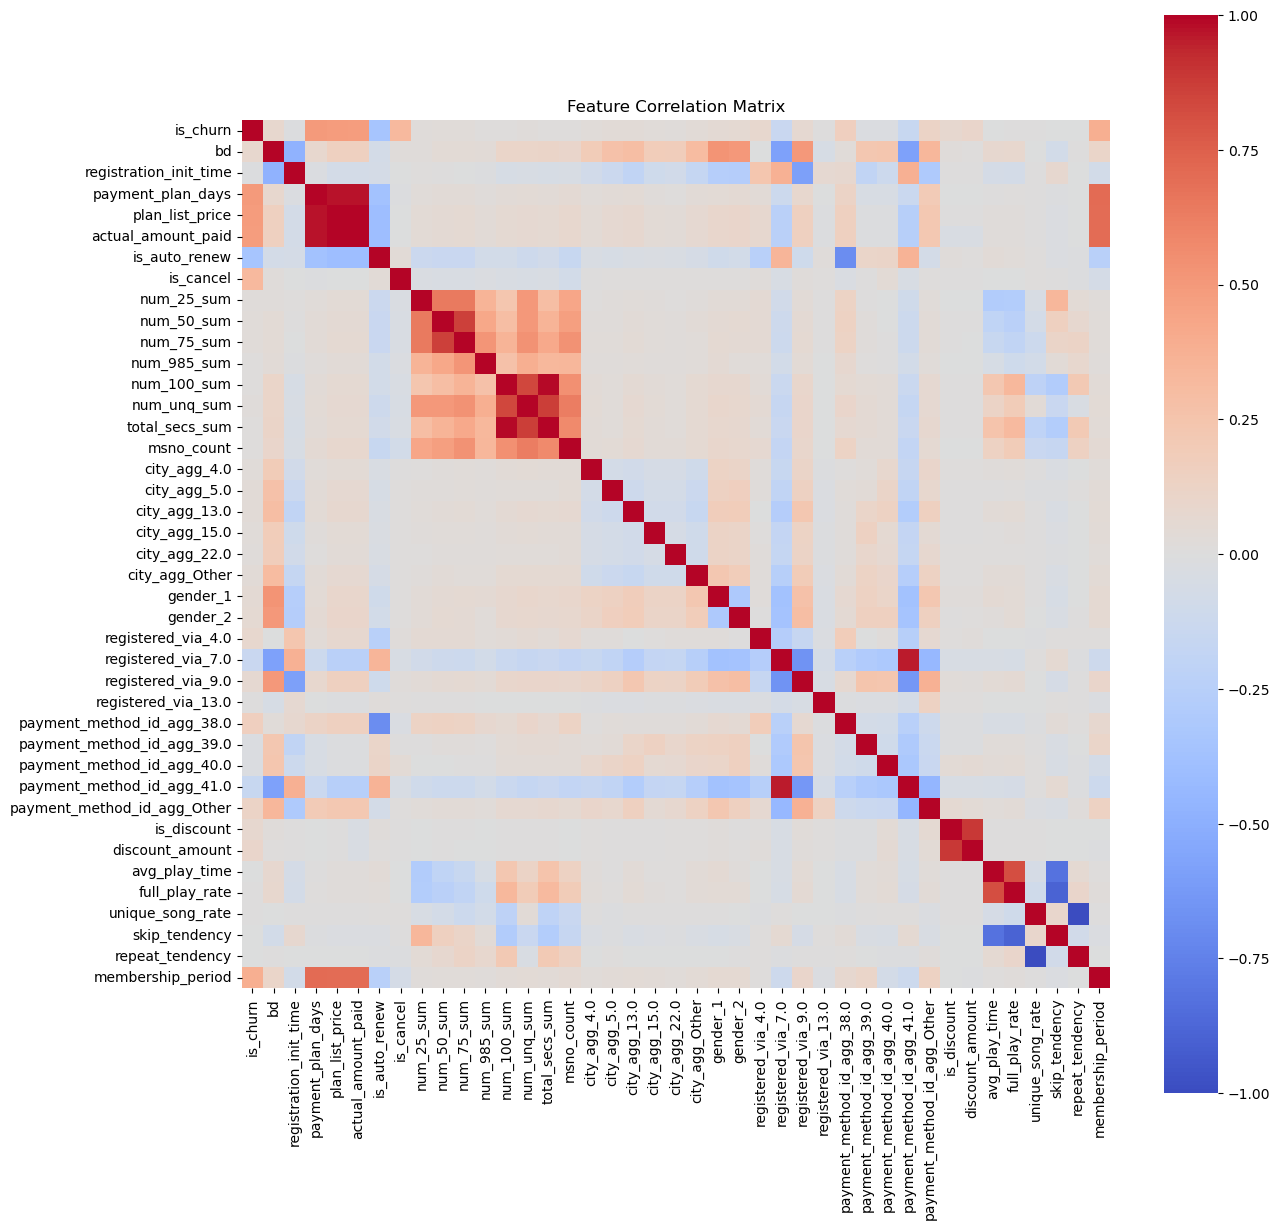

In [27]:
# Calculate the correlation matrix
correlation_matrix = train_cleaned.corr()

# Plot the heatmap of the correlation matrix
plt.figure(figsize=(14, 14))
sns.heatmap(correlation_matrix, cmap='coolwarm', square=True, annot=False)
plt.title('Feature Correlation Matrix')
plt.show()


From the heatmap, it's visually evident that several features exhibit strong correlations. The next step is to specifically list feature pairs with high correlation (for instance, correlation coefficients of 0.8 or above).

In [28]:
# Identify feature pairs with high correlation (correlation coefficients of 0.8 or above)
high_correlation_pairs = {}

for col in correlation_matrix.columns:
    for idx in correlation_matrix.index:
        if col != idx and abs(correlation_matrix.loc[idx, col]) >= 0.8:
            high_correlation_pairs[(col, idx)] = correlation_matrix.loc[idx, col]

# Display feature pairs with high correlation and their correlation coefficients
high_correlation_pairs

{('payment_plan_days', 'plan_list_price'): 0.9709161396143247,
 ('payment_plan_days', 'actual_amount_paid'): 0.9704373434083474,
 ('plan_list_price', 'payment_plan_days'): 0.9709161396143247,
 ('plan_list_price', 'actual_amount_paid'): 0.9992363909824105,
 ('actual_amount_paid', 'payment_plan_days'): 0.9704373434083474,
 ('actual_amount_paid', 'plan_list_price'): 0.9992363909824105,
 ('num_50_sum', 'num_75_sum'): 0.8624733979197027,
 ('num_75_sum', 'num_50_sum'): 0.8624733979197027,
 ('num_100_sum', 'num_unq_sum'): 0.8416948555632274,
 ('num_100_sum', 'total_secs_sum'): 0.985850914155911,
 ('num_unq_sum', 'num_100_sum'): 0.8416948555632274,
 ('num_unq_sum', 'total_secs_sum'): 0.8744131646693786,
 ('total_secs_sum', 'num_100_sum'): 0.985850914155911,
 ('total_secs_sum', 'num_unq_sum'): 0.8744131646693786,
 ('registered_via_7.0', 'payment_method_id_agg_41.0'): 0.9590614176619775,
 ('payment_method_id_agg_41.0', 'registered_via_7.0'): 0.9590614176619775,
 ('is_discount', 'discount_amount'

In [29]:
# Drop columns with high correlation and unnecessary features
train_cleaned = train_cleaned.drop(columns=[
    'plan_list_price', 'unique_song_rate', 'num_25_sum', 'num_50_sum', 
    'num_75_sum', 'num_985_sum', 'num_100_sum', 
    'num_unq_sum', 'total_secs_sum', 'registered_via_7.0',
    'transaction_date', 'membership_expire_date'
])

# Display the first few rows of the updated data
train_cleaned.head()

,msno,is_churn,bd,registration_init_time,payment_plan_days,actual_amount_paid,is_auto_renew,is_cancel,msno_count,city_agg_4.0,...,payment_method_id_agg_40.0,payment_method_id_agg_41.0,payment_method_id_agg_Other,is_discount,discount_amount,avg_play_time,full_play_rate,skip_tendency,repeat_tendency,membership_period
1,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,1,20,20131223.0,30,180.0,0,0,6.0,0,...,0,0,0,0,0.0,218.328406,0.812500,0.000000,0.062500,17266
2,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,1,18,20131227.0,90,300.0,0,0,20.0,0,...,0,0,1,0,0.0,122.181022,0.369369,0.430631,0.221622,17331
4,K6fja4+jmoZ5xG6BypqX80Uw/XKpMgrEMdG2edFOxnA=,1,35,20140125.0,30,99.0,1,0,15.0,0,...,0,1,0,0,0.0,243.288277,0.975659,0.009128,0.444219,17426
5,ibIHVYBqxGwrSExE63/omeDD99M5vYB3CN2HzkEY+eM=,1,0,20140126.0,30,149.0,1,1,4.0,0,...,1,0,0,0,0.0,206.340102,0.755102,0.122449,0.020408,17238
7,moRTKhKIDvb+C8ZHOgmaF4dXMLk0jOn65d7a8tQ2Eds=,1,28,20140202.0,410,1788.0,0,0,31.0,0,...,0,0,0,0,0.0,249.213192,0.876607,0.066838,0.350471,17663


## Checkpoint

In [30]:
train_cleaned.to_csv('/Users/halmorishima/Github/mycaprepo/data/train_cleaned2.csv', index=False)

In [31]:
# Randomly sample 10000 rows from each DataFrame
train_cleaned_sample2 = train_cleaned.sample(n=10000, random_state=42)

# Save the randomly picked rows to new CSV files
train_cleaned_sample2.to_csv('/Users/halmorishima/Github/mycaprepo/data/train_cleaned_sample2.csv', index=False)